<a href="https://colab.research.google.com/github/RichardKameri/FINAL_PROJECT_SENTIMENT_ANALYSISNT-/blob/main/KQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kenya Airways Customer Review Sentiment Analysis
Kenya Airways Logo
**bold text**
**Business Overview**

Kenya Airways is among the top airlines in Africa, and in Kenya, it holds a prominent position as the flag carrier and the largest airline in the country. Since its establishment in 1977, Kenya Airways has been a key player in both domestic and international air travel, connecting Kenya to various destinations around the world. The airline is known for its commitment to providing safe, reliable, and comfortable air travel experiences to its passengers. Over the years, Kenya Airways has built a strong brand reputation, emphasizing its African heritage and hospitality.

**Project Overview**

The aim of this project is to conduct sentiment analysis on customer reviews related to Kenya Airways. By analyzing the sentiments expressed in these reviews, we seek to gain insights into how customers perceive their experiences with the airline's services. This analysis will provide valuable feedback that can be used to enhance customer satisfaction, identify areas for improvement, and make informed business decisions to maintain and improve the airline's reputation.

Project Objectives


Sentiment Classification: Develop a sentiment classification model that can accurately categorize customer reviews into positive, negative, or neutral sentiments. This model will help automate the process of analyzing large volumes of reviews.

Feedback Analysis: Identify common themes and specific aspects mentioned in the reviews, such as in-flight services, customer service, booking process, seating comfort, and more. This will provide a comprehensive understanding of what aspects are contributing to positive or negative sentiments.

**Data Importation**

In [1]:
# Import all the necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import vader
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from nltk.probability import FreqDist
import nltk.collocations as collocations
from nltk import FreqDist, bigrams

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
def scrape_airline_reviews(base_url, pages, page_size):
    reviews = []
    date = []

    for i in range(1, pages + 1):
        print(f"Scraping page {i}")
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        response = requests.get(url)
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')

        for review in parsed_content.find_all("article", {"itemprop": "review"}):
            # Extract review text
            review_text = review.find("div", {"class": "text_content"}).get_text()
            reviews.append(review_text)

            # Extract date
            try:
                review_date = review.find("div", {"class": "body"}).find("time").get_text()
            except AttributeError:
                review_date = "N/A"
            date.append(review_date)

        print(f"   ---> {len(reviews)} total reviews")

    return reviews, date

# Define parameters
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways/"
pages = 6
page_size = 100

# Call the function
reviews, date = scrape_airline_reviews(base_url, pages, page_size)

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 496 total reviews
Scraping page 6
   ---> 496 total reviews


In [3]:
# Create a Dataframe to store the data

df = pd.DataFrame({"reviews":reviews, "date":date})
df.head()

,reviews,date
0,"✅ Trip Verified | Terrible experience, 12 hr...",23rd January 2025
1,✅ Trip Verified | I just completed a direct fl...,30th December 2024
2,✅ Trip Verified | Worst airline I've ever de...,24th December 2024
3,"Not Verified | By far, the worst customer ser...",4th December 2024
4,Not Verified | My experience with Kenya Airwa...,4th December 2024


In [6]:
import os

# ... your existing code ...

# Create the 'data' directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Saves the dataframe as a csv file in the data folder.
cwd = os.getcwd()
df.to_csv(cwd + "/data/KQ_reviews.csv")

In [7]:
# Inspect index 0

df['reviews'].get(0)

'✅ Trip Verified |   Terrible experience, 12 hrs stuck in Nairobi. Getting emails about flight delay due to technical fault but none of the staff in the airport aware. No real life support provided. Terrible service from this airline. Avoid if possible.'

In [8]:
# Class used to Describe the Data

class Describer:

    # initialize object
    def __init__(self, df):
        self.df = df

    # method to check shape of data
    def shape(self):
        shape_df = print(f"The DataFrame has:\n\t* {self.df.shape[0]} rows\n\t* {self.df.shape[1]} columns", '\n')
        return shape_df

    # method to check info on dataset
    def data_info(self):
        info_df = print(self.df.info(), '\n')
        return info_df

    # method to describe numerical columns
    def data_describe(self):
        num_col = self.df.describe()
        return num_col

In [9]:
# creating an instance of the class describer
describe_df = Describer(df)

# Viewing the shape of the data
describe_df.shape()

The DataFrame has:
	* 496 rows
	* 2 columns 



In [10]:
# summary information
print('Summary infomation on dataset')
print('______________________________')
describe_df.data_info()

Summary infomation on dataset
______________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  496 non-null    object
 1   date     496 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB
None 



Data **Cleaning**

In [11]:
# Convert the date column to date time

df['date'] = pd.to_datetime(df['date'].str.replace(r'(?<=\d)(st|nd|rd|th)', '', regex=True))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   reviews  496 non-null    object        
 1   date     496 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 7.9+ KB


**Data Understanding**

The data was scraped using BeautifulSoup from this website. The website contains various reviews related to Air Travel.

In [12]:
# Function to calculate word count
def word_count(text):
    words = text.split()
    return len(words)

# Calculate word count for each review
df['word_count'] = df['reviews'].apply(word_count)

# Calculate and print the average word count
avg_word_count = df['word_count'].mean()

# Display the updated DataFrame
avg_word_count

153.95967741935485

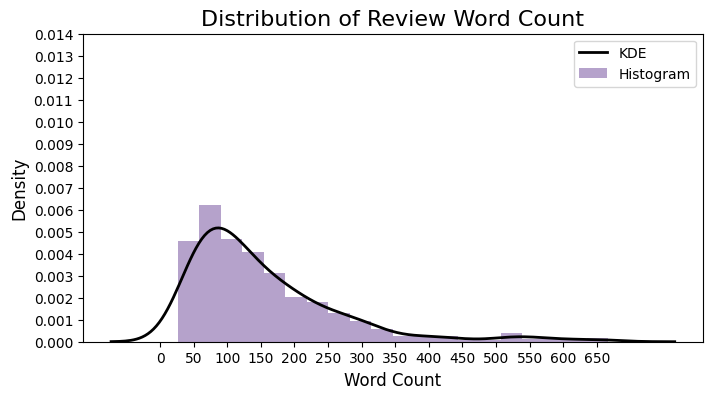

In [13]:
# Plot a histogram of the word counts
fig = plt.figure(figsize=(8, 4))

plt.hist(df['word_count'], bins=20, color='#967bb6', alpha=0.7, density=True)

# KDE plot
sns.kdeplot(df['word_count'], color='black', linewidth=2)

plt.title('Distribution of Review Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(np.arange(0, 700, 50))
plt.yticks(np.arange(0, 0.015, 0.001))

plt.legend(labels=['KDE', 'Histogram'])

plt.show()

In [14]:
# Creates a new column that extracts the information on whether the trip is verified or not

df['verified'] = df.reviews.str.contains("Trip Verified")

**Data Pre-Processing**


Data preprocessing in NLP sentiment analysis involves cleaning and structuring text data for accurate analysis. It includes steps like removing special characters, tokenizing text, eliminating common words, stemming or lemmatization, handling negations, and converting text into numerical vectors. This ensures that the text data is ready for machine learning models and results in more reliable sentiment analysis outcomes.

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Creates a new column that extracts the information on whether the trip is verified or not

reviews_data = df.reviews.str.strip("Trip Verified |")
corpus =[]
# Instantiate the WordNetLemmatizer
lemma = WordNetLemmatizer()

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = " ".join(rev)
    corpus.append(rev)

In [20]:
#Removing unwanted text(first text preprocessing)
df.replace(re.compile(r'\s*✅ Trip Verified \|\s*'), '', inplace=True)

df.head(8)

,reviews,date,word_count,verified
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False
5,My wife flew Kigali-Dar return November 2024. ...,2024-12-02,121,True
6,First flight I was appalled by the state of th...,2024-11-30,64,True
7,Not Verified | Avoid Kenya Airways at all cost...,2024-11-29,155,False


In [21]:
# add the corpus to the original dataframe

df['corpus'] = corpus
df


,reviews,date,word_count,verified,corpus
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True,trip verified terrible experience hrs stuck in...
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True,trip verified i just completed a direct flight...
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True,trip verified worst airline i ve ever dealt wi...
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False,not verified by far the worst customer service...
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False,not verified my experience with kenya airways ...
...,...,...,...,...,...
491,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb this trip showed both the good and...
492,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge in nairobi was small and...
493,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london as me and my wife are both whee...
494,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw in economy adequate for a hr trip fa w...


In [23]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [24]:
# an instance of SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon') #Download the VADER lexicon.
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

# a new column named 'sentiment'
df['sentiment'] = df['reviews'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )
df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviews,date,word_count,verified,corpus,sentiment
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True,trip verified terrible experience hrs stuck in...,-0.8820
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True,trip verified i just completed a direct flight...,-0.8093
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True,trip verified worst airline i ve ever dealt wi...,0.6164
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False,not verified by far the worst customer service...,-0.9459
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False,not verified my experience with kenya airways ...,0.6446
...,...,...,...,...,...,...
491,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb this trip showed both the good and...,0.8201
492,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge in nairobi was small and...,0.9826
493,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london as me and my wife are both whee...,0.9485
494,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw in economy adequate for a hr trip fa w...,0.6808


In [25]:
# Creating another new column called 'sentiment_type' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'sentiment' column
df['sentiment_type'] = df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
df

,reviews,date,word_count,verified,corpus,sentiment,sentiment_type
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True,trip verified terrible experience hrs stuck in...,-0.8820,negative
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True,trip verified i just completed a direct flight...,-0.8093,negative
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True,trip verified worst airline i ve ever dealt wi...,0.6164,positive
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False,not verified by far the worst customer service...,-0.9459,negative
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False,not verified my experience with kenya airways ...,0.6446,positive
...,...,...,...,...,...,...,...
491,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb this trip showed both the good and...,0.8201,positive
492,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge in nairobi was small and...,0.9826,positive
493,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london as me and my wife are both whee...,0.9485,positive
494,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw in economy adequate for a hr trip fa w...,0.6808,positive


**Exploratory Data Analysis (EDA)**

In this stage EDA is also done on the dataset to gain more insights on the data that is available.

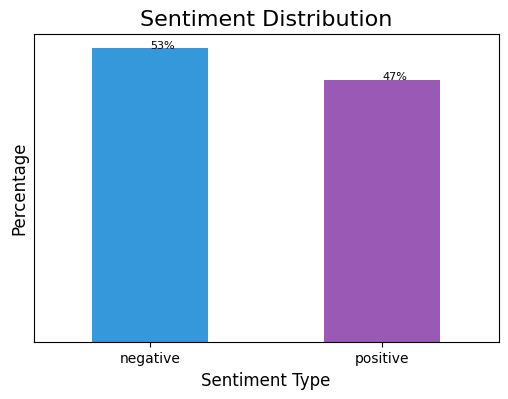

In [26]:
# Calculate the percentage of each type of sentiment score
sent_type_percentages = df['sentiment_type'].value_counts(normalize=True) * 100

# Define custom colors for the bars

bar_colors = ['#3498db', '#9b59b6']

# Plot the sentiment percentages as a bar plot
fig, ax = plt.subplots(figsize=(6, 4))
sent_type_percentages.plot(kind='bar', color=bar_colors, ax=ax)

# Add data labels on the bars with two decimal points
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='left', va='baseline', fontsize=8, color='black')

ax.set_title('Sentiment Distribution', fontsize=16)
ax.set_xlabel('Sentiment Type', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticklabels(sent_type_percentages.index, rotation=0)
ax.set_yticks([])  # Hide y-axis ticks

plt.show()

Negative reviews account for 51% of the dataset, and positive reviews account for 49% of the dataset.
Understanding what is the reason behind the negative reviews is the main concern of this project.

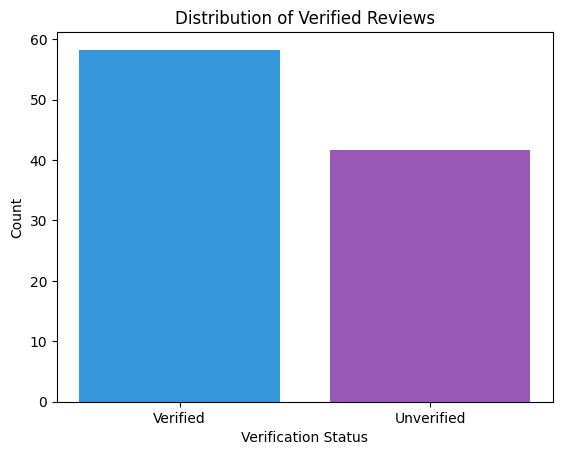

In [27]:
# Calculate the counts of verified and unverified reviews
verified_counts = df['verified'].value_counts(normalize=True)*100

# Define custom colors for the bars
bar_colors = ['#3498db', '#9b59b6']

# Create the bar chart with custom colors
plt.bar(verified_counts.index, verified_counts.values, color=bar_colors)

# Add labels and title
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Distribution of Verified Reviews')

# Customize x-axis tick labels
plt.xticks(verified_counts.index, ['Verified', 'Unverified'])

# Show the plot
plt.show()

Majority of the reviews have been verified.

In [28]:
# Cleaned data
df.to_csv( cwd + "/data/reviews_cleaned.csv")

In [29]:
# Time Series Analysis on the Date column
fig = px.line(df, x='date')
fig.show()


There is a decline on the number of reviews that have been shared

In [30]:
# make a frequency chart that will tell us the key topics that are mentioned in the reviews

reviews = df['corpus']

# Convert the reviews into a list of words

words = []
for review in reviews:
    words.extend(review.split())


# Filter out the remaining stopwords

stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]

In [32]:
# Get the top 20 most used words
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out any of the remaining stop words
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]

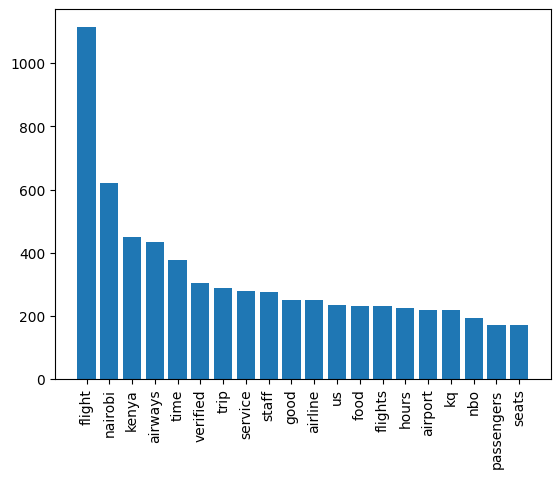

In [33]:
# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

#Display the plot
plt.show()

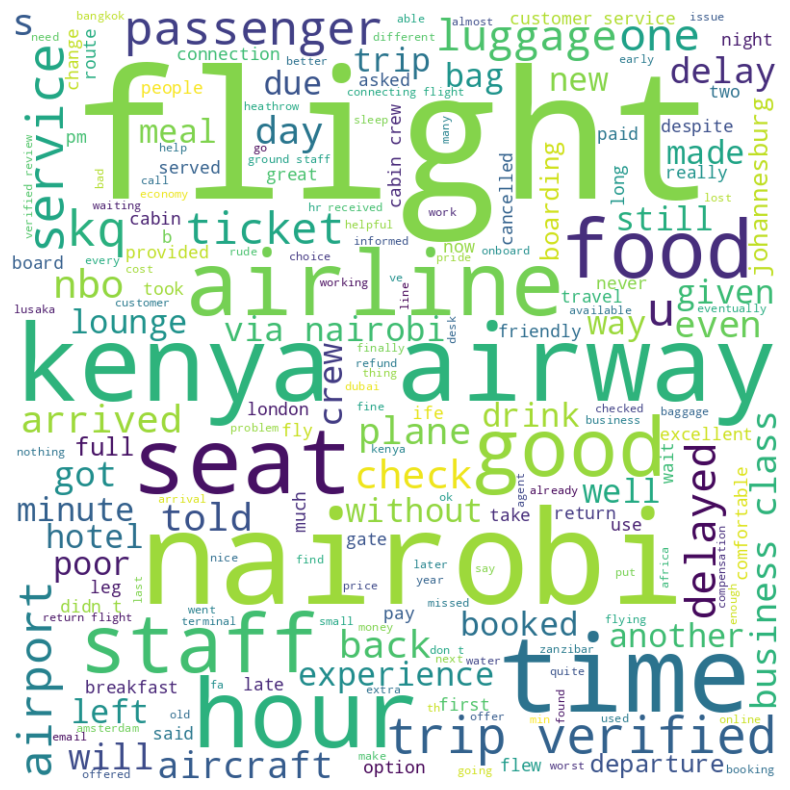

In [36]:
reviews = " ".join(df.corpus)

# Load the airplane image


# Set stopwords
stopwords = set(STOPWORDS)

# Create a WordCloud instance with the airplane mask
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    contour_width=1,
    contour_color="black"
).generate(reviews)

# Display the WordCloud with the airplane mask
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
#split the text of all reviews into a list of words
words = reviews.split(" ")

#remove certain words that will not be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'kq', "passenger","u","airway","airline",
                                           "nairobi","plane","via","nbo"])


new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

#create a dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))

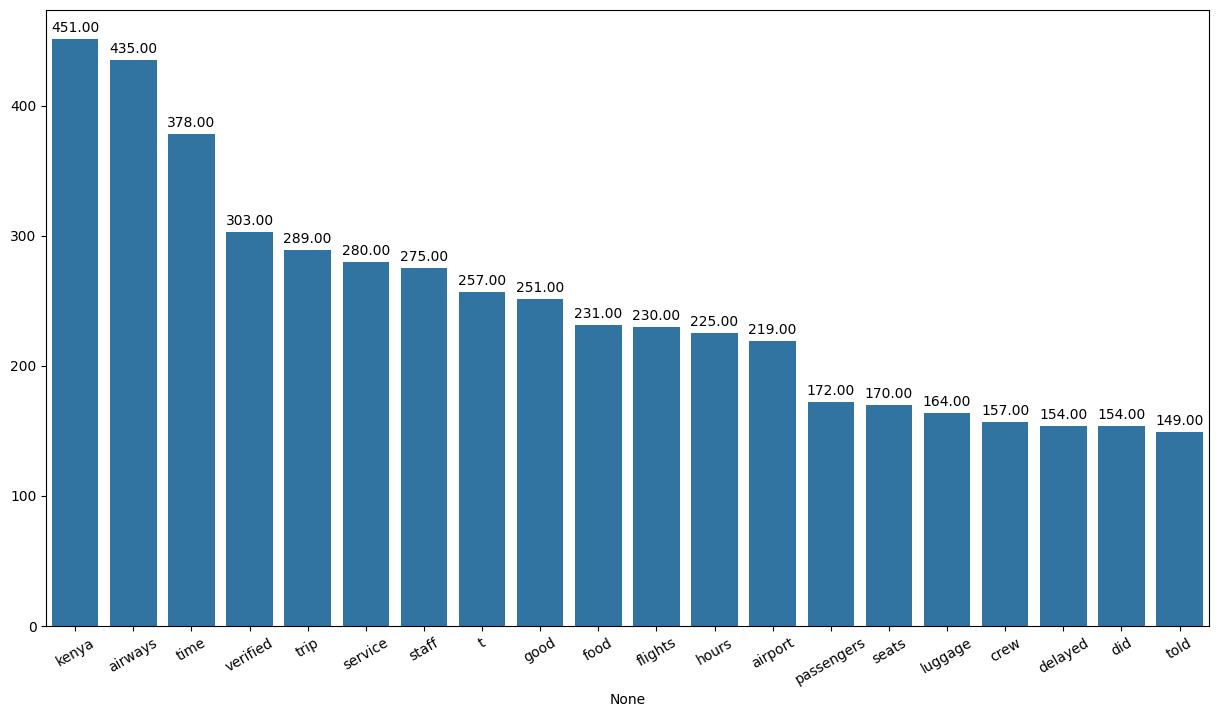

In [38]:
# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15, 8))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)

# Add labels to the bars
for container in all_plot.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=30)

# Display the plot
plt.show()

**Word Frequency using N-gram**


Word frequency with N-grams means looking at how often specific sets of N words appear together in a text. These sets give us insights into word patterns and connections.

<Axes: >

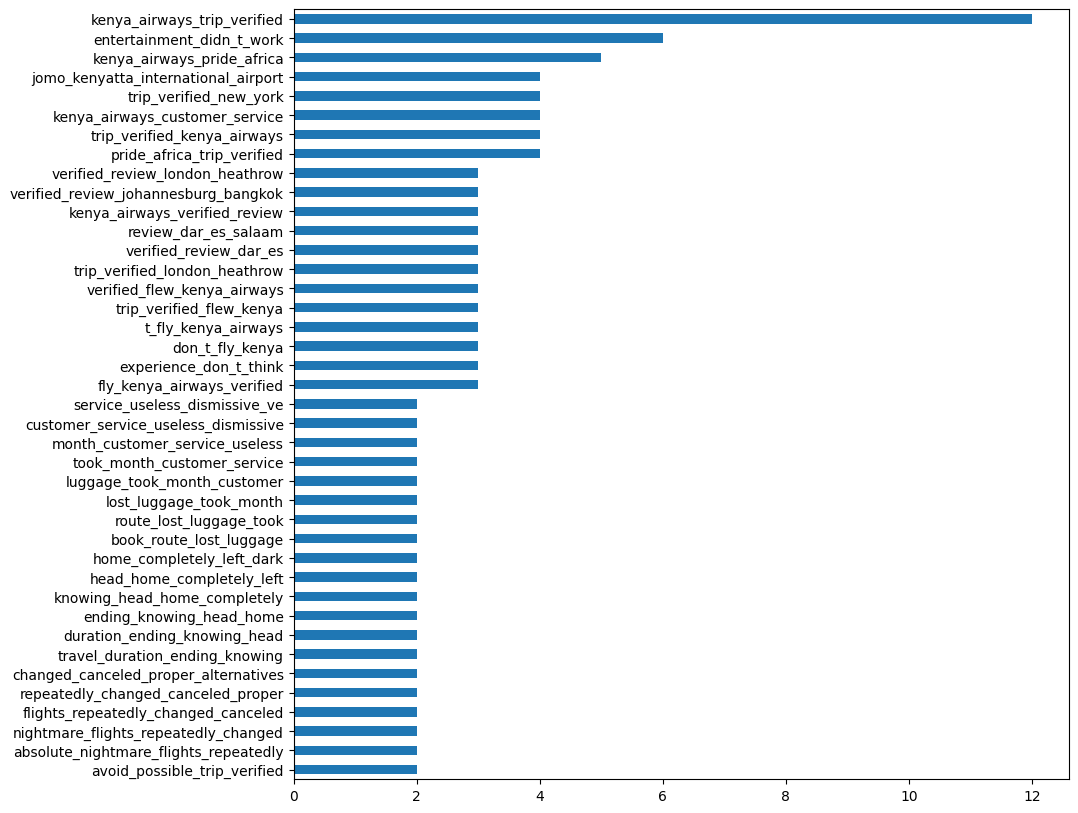

In [39]:
reviews = " ".join(df.corpus)

# Split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words, number_of_ngrams):
    # Generate n-grams
    ngrams_list = list(ngrams(new_words, number_of_ngrams))

    # Creating FreqDist
    ngram_fd = FreqDist(ngrams_list).most_common(40)

    # Sort values by highest frequency
    ngram_sorted = {k: v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Join n-gram tokens with '_' and maintain sorting
    ngram_joined = {'_'.join(k): v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Convert to Pandas Series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind="barh")

    return ax

get_freq_dist(new_words, 4)

In [40]:
%%capture
vds = SentimentIntensityAnalyzer()

df['label'] = 0

for i in range(len(df.corpus)):

    score = vds.polarity_scores(df.corpus[i])['compound']
    # Positive sentiments
    if score > 0.2:
        df['label'][i] = 1
        # Negative sentiments
    elif score < 0:
        df['label'][i] = -1

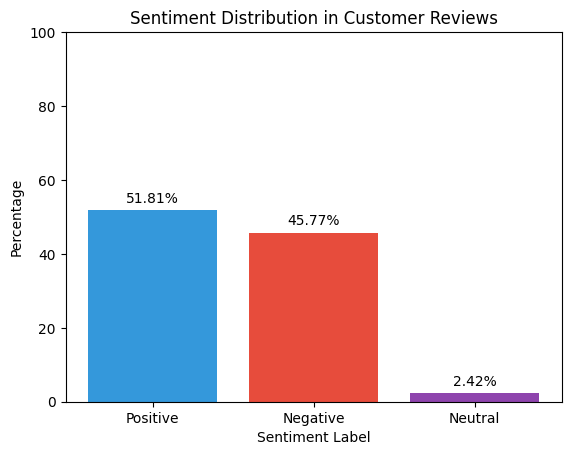

In [41]:
# Calculate label distribution percentages
label_percentages = df.label.value_counts(normalize=True) * 100

# Bar chart
colors = ['#3498db','#e74c3c', '#8e44ad',]
labels = ['Positive', 'Negative', 'Neutral']

plt.bar(labels, label_percentages, color=colors)
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution in Customer Reviews')
plt.ylim(0, 100)

# Display percentages on the bars
for i, percentage in enumerate(label_percentages):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', color='black')

plt.show()

In [44]:
# Create an object of CountVectorizer
vect = CountVectorizer()

# Convert the corpus to a list of strings (if not already)
corpus = df.corpus.tolist()

# Apply transformation
tf = vect.fit_transform(corpus)
tf_array = tf.toarray()

# Get the feature names
tf_feature_names = vect.get_feature_names_out()

In [45]:
#declare the number of topics
number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit the term frequency data to the model
model.fit(tf)

#create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

#loop through model components
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]

df_topic = pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights
0,the,2041.6,hostesses,2.9,no,27.0,to,38.1,to,771.0,est,7.2,to,775.0,to,114.6
1,and,1428.9,hospitality,2.1,in,15.9,and,20.3,the,756.3,de,7.2,the,550.9,the,98.1
2,to,1059.6,treat,2.1,to,13.5,you,16.8,we,458.9,la,6.1,and,327.6,and,52.2
3,was,1010.1,honestly,1.1,on,12.1,they,12.2,and,458.0,et,5.1,in,300.2,of,51.4
4,on,728.2,mobile,1.1,nairobi,11.3,not,9.9,was,336.7,is,4.2,flight,279.0,they,51.0
5,in,617.3,secured,1.1,the,11.2,flight,9.5,flight,287.5,le,4.1,my,268.2,we,48.3
6,flight,538.6,finished,1.1,we,10.5,it,7.8,our,236.3,total,4.1,for,236.5,our,32.8
7,of,462.8,waste,1.1,for,10.1,them,7.7,in,233.4,of,3.7,was,234.3,is,28.3
8,were,409.2,recently,1.1,de,10.1,that,6.9,of,226.9,pour,3.1,that,209.1,their,26.8
9,with,377.2,penny,1.1,dar,10.0,was,6.7,were,209.0,vraiment,3.1,at,199.1,have,24.9


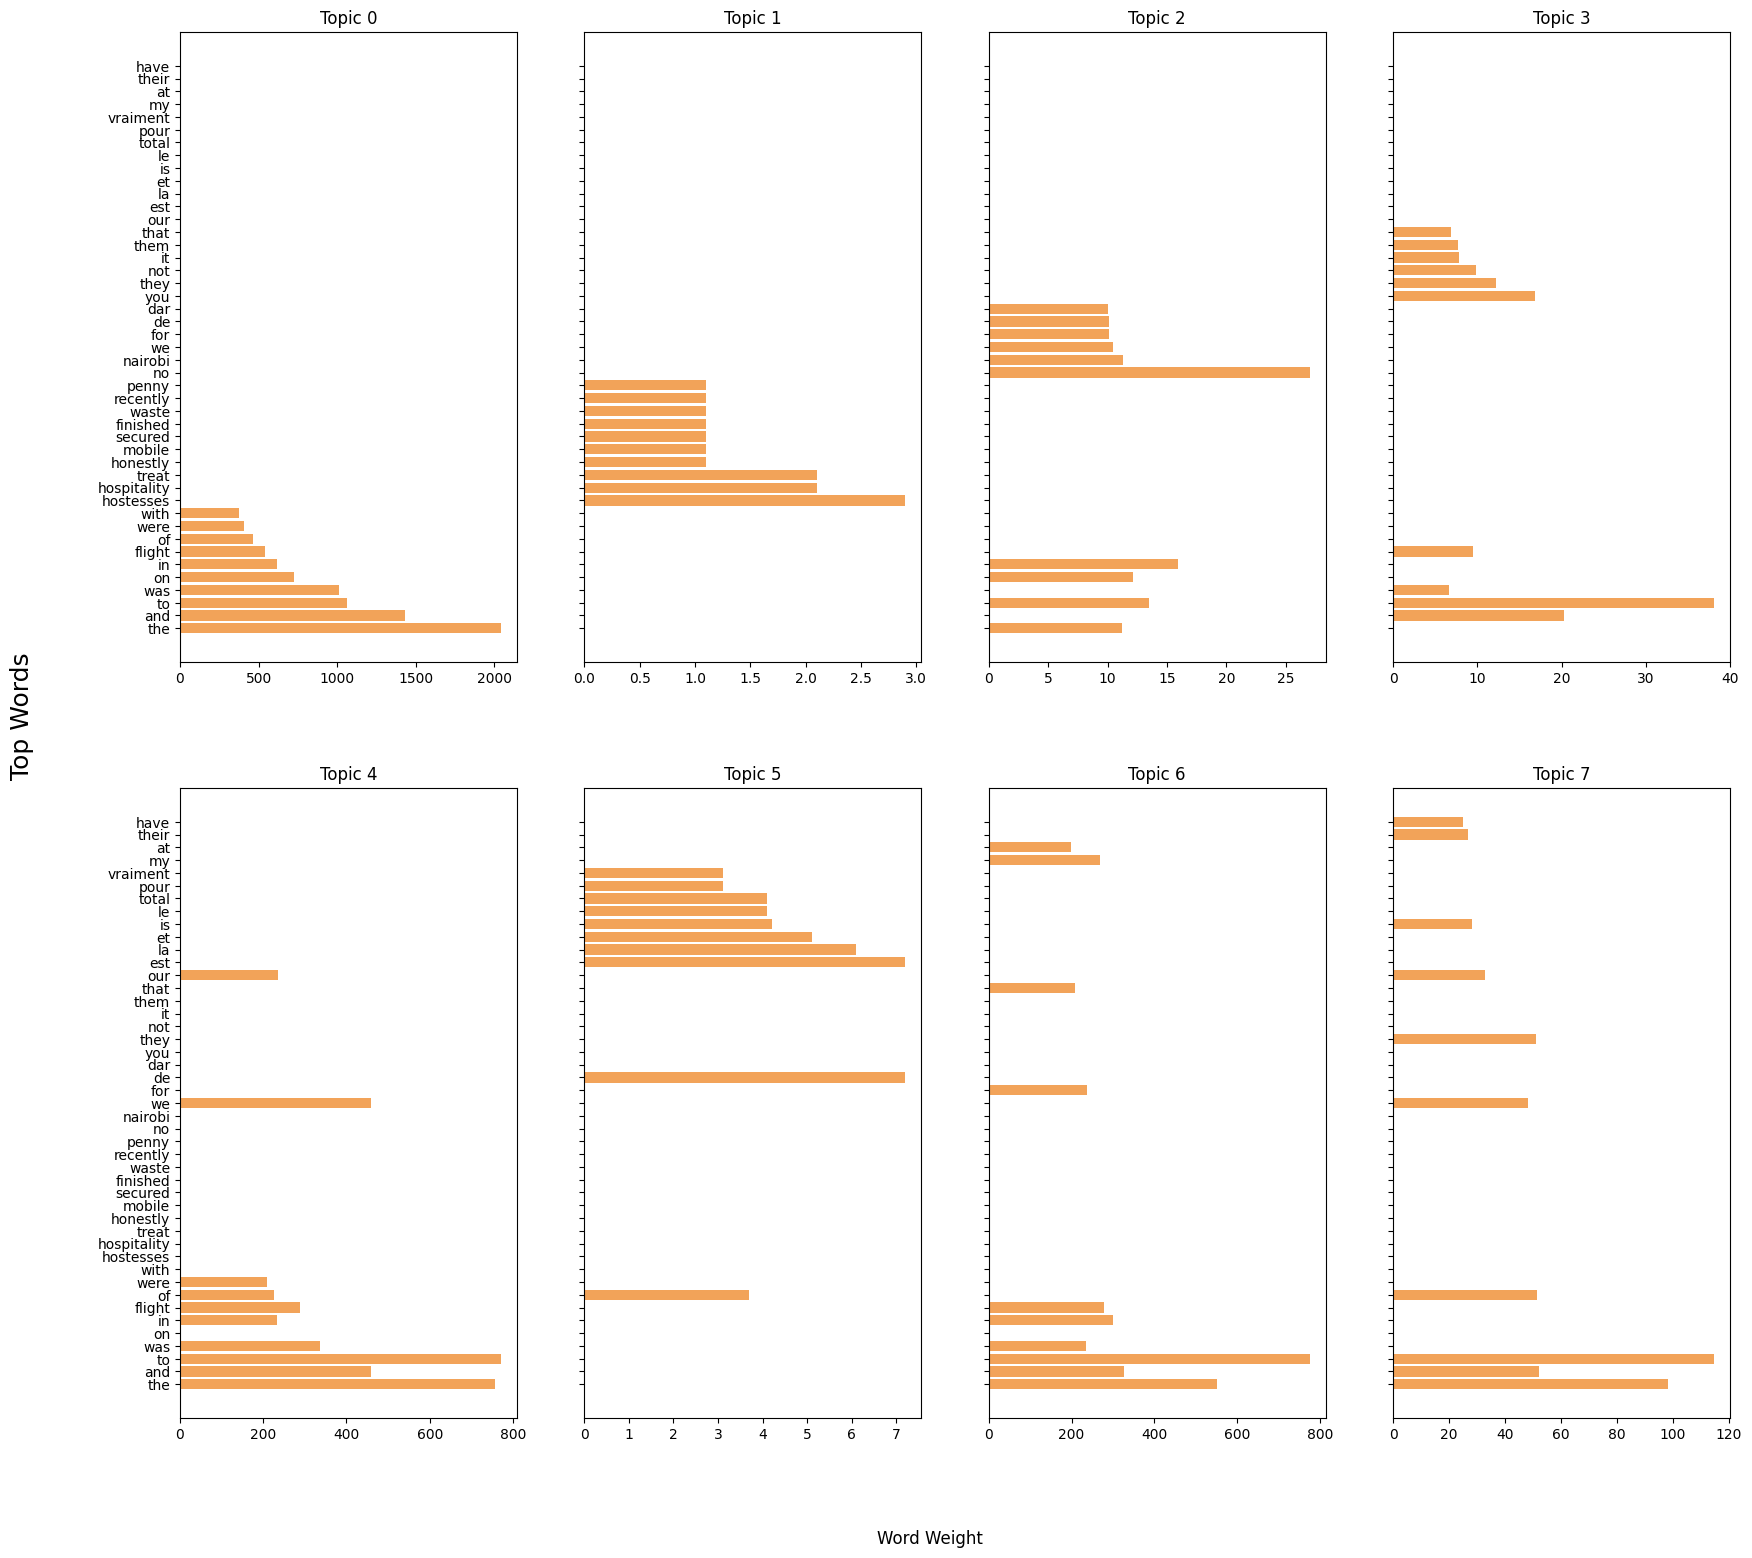

In [46]:
# Create subplots for each topic in a 2x2 grid
fig, axes = plt.subplots(2, 4, figsize=(20,18), sharey=True)

# Flatten the 2D axes array
axes = axes.flatten()

# Iterate over the topics and available subplots
for topic_idx, ax in enumerate(axes):
    if topic_idx < number_of_topics:  # Only plot if there are available subplots
        words = topic_dict[f"Topic {topic_idx} words"]
        weights = [float(w) for w in topic_dict[f"Topic {topic_idx} weights"]]

        ax.barh(words, weights, color='#f2a359')
        ax.set_title(f"Topic {topic_idx}")
        ax.invert_yaxis()

# Add common labels
fig.text(0.5, 0.04, 'Word Weight', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Top Words', va='center', rotation='vertical', fontsize=18)

plt.show()